In [1]:
import sys; sys.path += ['..', '../src']

Now we should initialize our transformer with learnt embeddings, initialize discriminator and add adversarial loss.
When we are done with that — we are only left with training the thing!

In [2]:
import os
from src.vocab import Vocab

DATA_PATH = '../data/generated'
max_len = 50 # Processing long sentences is slow

train_src_path = os.path.join(DATA_PATH, 'train.en.tok.bpe')
train_trg_path = os.path.join(DATA_PATH, 'train.de.tok.bpe')
val_src_path = os.path.join(DATA_PATH, 'val.en.tok.bpe')
val_trg_path = os.path.join(DATA_PATH, 'val.de.tok.bpe')

train_src = open(train_src_path, 'r', encoding='utf-8').read().splitlines()
train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()
val_src = open(val_src_path, 'r', encoding='utf-8').read().splitlines()
val_trg = open(val_trg_path, 'r', encoding='utf-8').read().splitlines()

train_src = [s.split()[:max_len-2] for s in train_src]
train_trg = [s.split()[:max_len-2] for s in train_trg]
val_src = [s.split()[:max_len-2] for s in val_src]
val_trg = [s.split()[:max_len-2] for s in val_trg]

vocab_src = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.en'))
vocab_trg = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.de'))

train_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in train_src]
train_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in train_trg]
val_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in val_src]
val_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in val_trg]

In [3]:
import os

from src.transformer.models import Transformer
from src.utils.data_utils import load_embeddings, init_emb_matrix
from src.models import FFN

transformer = Transformer(len(vocab_src), len(vocab_trg), max_len)
discriminator = FFN(512, 2, 512)

# Initializing transformer encoder and decoder with embeddings
# embeddings_src = load_embeddings('../trained_models/wmt17.en.tok.bpe_cbow.vec')
# embeddings_trg = load_embeddings('../trained_models/wmt17.de.tok.bpe_cbow.vec')

# init_emb_matrix(transformer.encoder.src_word_emb.weight.data, embeddings_src, vocab_src.token2id)
# init_emb_matrix(transformer.decoder.tgt_word_emb.weight.data, embeddings_trg, vocab_trg.token2id)

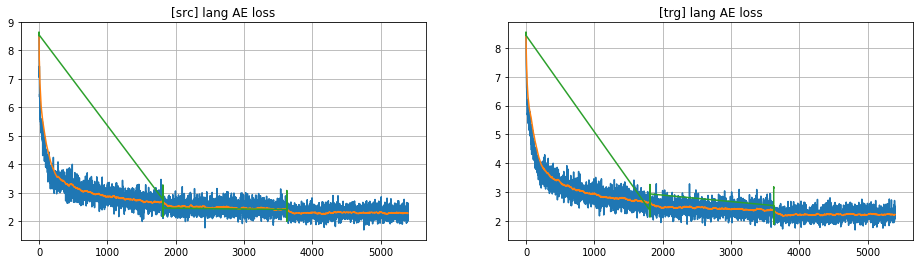

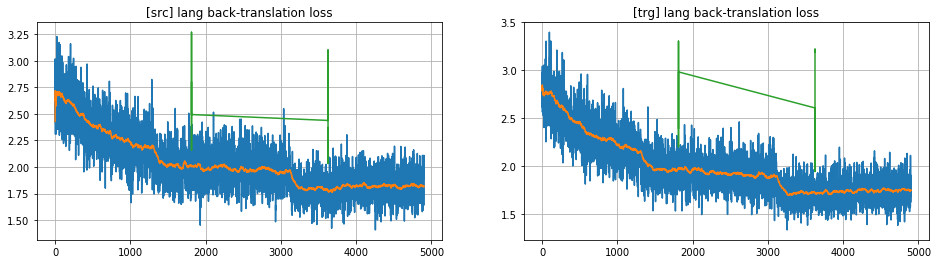

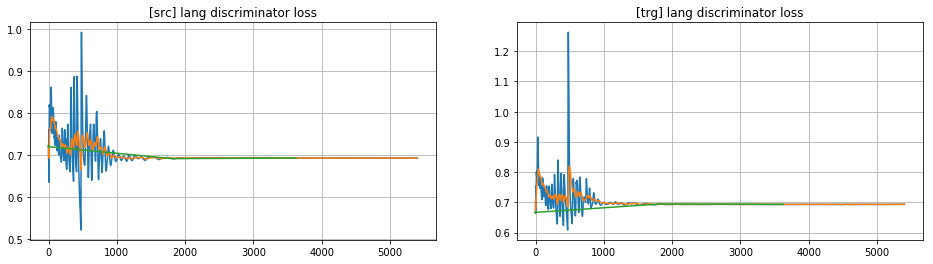

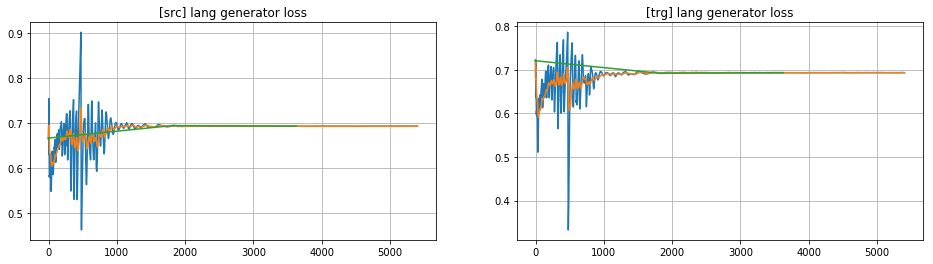

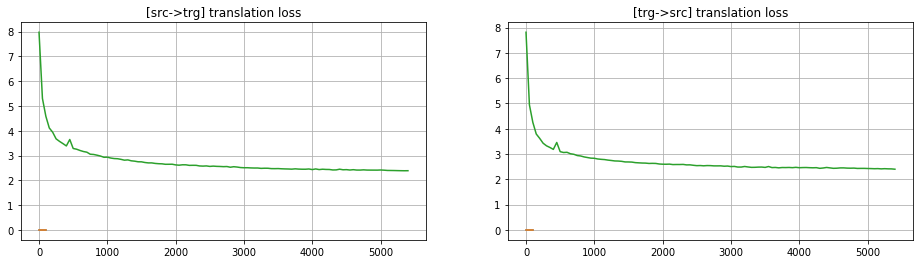

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam, RMSprop
from tqdm import tqdm
tqdm.monitor_interval = 0

%matplotlib inline

from src.trainer import Trainer
from src.utils.umt_batcher import UMTBatcher
from src.utils.data_utils import Batcher
import src.transformer.constants as constants

use_cuda = torch.cuda.is_available()

def reconstruction_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)

reconstruct_src_criterion = reconstruction_criterion(len(vocab_src))
reconstruct_trg_criterion = reconstruction_criterion(len(vocab_trg))
adv_criterion = nn.BCELoss()

transformer_optimizer = Adam(transformer.get_trainable_parameters(), lr=3e-4, betas=(0.5, 0.999))
transformer_bt_optimizer = Adam(transformer.get_trainable_parameters(), lr=1e-5)
discriminator_optimizer = Adam(discriminator.parameters(), lr=1e-4)

training_data = UMTBatcher(train_src_idx, train_trg_idx, vocab_src,
                           vocab_trg, batch_size=16, shuffle=True)
val_data = UMTBatcher(val_src_idx, val_trg_idx, vocab_src,
                      vocab_trg, batch_size=16, shuffle=True)
translation_val_data = Batcher(val_src_idx, val_trg_idx, vocab_src.token2id,
                               vocab_trg.token2id, batch_size=16, shuffle=True)

training_config = {
    'max_num_epochs': 3,
    'start_bt_from_iter': 500
}

trainer = Trainer(transformer, discriminator,
                  transformer_optimizer, discriminator_optimizer, transformer_bt_optimizer,
                  reconstruct_src_criterion, reconstruct_trg_criterion, adv_criterion,
                  training_config)

trainer.run_training(training_data, val_data, translation_val_data, plot_every=50, val_translate_every=50)

In [15]:
import numpy as np
from tqdm import tqdm

from src.utils.bleu import compute_bleu_for_sents
from src.utils.data_utils import Batcher

transformer.train()

val_data = Batcher(val_src_idx, val_trg_idx, vocab_src.token2id,
                   vocab_trg.token2id, batch_size=16, shuffle=True)

all_translations_src_to_trg = []
all_translations_trg_to_src = []
all_targets_src_to_trg = []
all_targets_trg_to_src = []

for test_batch in tqdm(val_data):
    translations_src_to_trg = transformer.translate_batch(test_batch[0], max_len=max_len, beam_size=4)
    translations_trg_to_src = transformer.translate_batch(test_batch[1], max_len=max_len,
                                                    beam_size=6, use_src_embs_in_decoder=True,
                                                    use_trg_embs_in_encoder=True)
    
    translations_src_to_trg = [vocab_trg.remove_bpe(vocab_trg.detokenize(t)) for t in translations_src_to_trg]
    translations_trg_to_src = [vocab_src.remove_bpe(vocab_src.detokenize(t)) for t in translations_trg_to_src]

    targets_src_to_trg = [vocab_trg.remove_bpe(vocab_trg.detokenize(s)) for s in test_batch[1].data]
    targets_trg_to_src = [vocab_src.remove_bpe(vocab_src.detokenize(s)) for s in test_batch[0].data]

    translations_src_to_trg = [' '.join(t.split()[:-1]) for t in translations_src_to_trg]
    translations_trg_to_src = [' '.join(t.split()[:-1]) for t in translations_trg_to_src]
    targets_src_to_trg = [' '.join(t.split()[1:-1]) for t in targets_src_to_trg]
    targets_trg_to_src = [' '.join(t.split()[1:-1]) for t in targets_trg_to_src]
    
    all_translations_src_to_trg += translations_src_to_trg
    all_translations_trg_to_src += translations_trg_to_src
    all_targets_src_to_trg += targets_src_to_trg
    all_targets_trg_to_src += targets_trg_to_src
    break

print('BLEU [src->trg]:', compute_bleu_for_sents(all_translations_src_to_trg, all_targets_src_to_trg))
print('BLEU [trg->src]:', compute_bleu_for_sents(all_translations_trg_to_src, all_targets_trg_to_src))

  0%|          | 0/64 [00:00<?, ?it/s]

BLEU [src->trg]: 0.0
BLEU [trg->src]: 0.0


In [16]:
for i in range(10):
    print('Prediction:', all_translations_src_to_trg[i])
    print('Target    :', all_targets_src_to_trg[i])

Prediction: Ein Mann in einem blauen Hemd und blauen Shorts und schwarzen Hosen sitzt auf einem Pferd
Target    : Ein brauner Hund rennt mit einem Stock im Maul über den Sand .
Prediction: Ein Mann in einem blauen Hemd und blauen Shorts sitzt auf einem Sofa
Target    : Ein Fotograf nimmt ein Bild von einem Hinweis auf ein paar Türen auf .
Prediction: Ein Mann in einem blauen T-Shirt sitzt auf einem Stuhl
Target    : Ein Mann in einer grauen Jacke transportiert Laub auf einem Fahrrad .
Prediction: Ein Mann fährt auf einem Fahrrad auf
Target    : Eine Menschenmasse geht durch den Park .
Prediction: Ein Mann in einem blauen T-Shirt und blauen Outfit fährt auf einem
Target    : Ein Frau in einer rosafarbenen Bluse zeigt einem Mann in einem gestreiften Pullover , wie eine Handarbeit aus Garn hergestellt wird .
Prediction: Ein Mann in einem blauen Hemd und blauen Shorts sitzt auf einer Bank
Target    : Eine Frau arbeitet am Wochenende an ihrer Terrasse .
Prediction: Ein Mann in einem blauen 